In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import log_loss
import pickle
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler



In [2]:
df = pd.read_csv(r'/Users/jamesjirsa/Desktop/Data_Science/JJ_Projects/UFC/new_method/scrape_ufc_stats/final_fight_data.csv')
df.columns.tolist()

['Unnamed: 0',
 'EVENT',
 'BOUT',
 'OUTCOME',
 'WEIGHTCLASS',
 'METHOD',
 'ROUND',
 'TIME',
 'TIME FORMAT',
 'REFEREE',
 'DETAILS',
 'URL',
 'FIGHTER',
 'RESULT',
 'TIME_IN_SECONDS',
 'DATE',
 'ELO_FIGHTER',
 'CUM_KD',
 'CUM_SIG.STR._Landed',
 'CUM_SIG.STR._Attempted',
 'CUM_SIG.STR._Attempted_avoided',
 'CUM_TOTAL STR._Landed',
 'CUM_TOTAL STR._Attempted',
 'CUM_TOTAL STR._Attempted_avoided',
 'CUM_TD_Landed',
 'CUM_TD_Attempted',
 'CUM_TD_Attempted_avoided',
 'CUM_HEAD_Landed',
 'CUM_HEAD_Attempted',
 'CUM_HEAD_Attempted_avoided',
 'CUM_BODY_Landed',
 'CUM_BODY_Attempted',
 'CUM_BODY_Attempted_avoided',
 'CUM_LEG_Landed',
 'CUM_LEG_Attempted',
 'CUM_LEG_Attempted_avoided',
 'CUM_DISTANCE_Landed',
 'CUM_DISTANCE_Attempted',
 'CUM_DISTANCE_Attempted_avoided',
 'CUM_CLINCH_Landed',
 'CUM_CLINCH_Attempted',
 'CUM_CLINCH_Attempted_avoided',
 'CUM_GROUND_Landed',
 'CUM_GROUND_Attempted',
 'CUM_GROUND_Attempted_avoided',
 'CUM_CTRL_TIME_IN_SECONDS',
 'CUM_SUB.ATT',
 'CUM_REV.',
 'CUM_RoundT

In [3]:
df['RESULT'] = np.where(df['RESULT'] == 'Win', 1,0)

In [4]:
features = df.columns[df.columns.get_loc('ELO_FIGHTER'):].tolist()
#features.remove('CUM_index')
features.remove('DOB')
df = df.dropna(subset = 'opponent_PC1')
#df = df.drop(['CUM_index'], axis = 1)

In [5]:
features

['ELO_FIGHTER',
 'CUM_KD',
 'CUM_SIG.STR._Landed',
 'CUM_SIG.STR._Attempted',
 'CUM_SIG.STR._Attempted_avoided',
 'CUM_TOTAL STR._Landed',
 'CUM_TOTAL STR._Attempted',
 'CUM_TOTAL STR._Attempted_avoided',
 'CUM_TD_Landed',
 'CUM_TD_Attempted',
 'CUM_TD_Attempted_avoided',
 'CUM_HEAD_Landed',
 'CUM_HEAD_Attempted',
 'CUM_HEAD_Attempted_avoided',
 'CUM_BODY_Landed',
 'CUM_BODY_Attempted',
 'CUM_BODY_Attempted_avoided',
 'CUM_LEG_Landed',
 'CUM_LEG_Attempted',
 'CUM_LEG_Attempted_avoided',
 'CUM_DISTANCE_Landed',
 'CUM_DISTANCE_Attempted',
 'CUM_DISTANCE_Attempted_avoided',
 'CUM_CLINCH_Landed',
 'CUM_CLINCH_Attempted',
 'CUM_CLINCH_Attempted_avoided',
 'CUM_GROUND_Landed',
 'CUM_GROUND_Attempted',
 'CUM_GROUND_Attempted_avoided',
 'CUM_CTRL_TIME_IN_SECONDS',
 'CUM_SUB.ATT',
 'CUM_REV.',
 'CUM_RoundTime',
 'CUM_SIG.STR._Landed_received',
 'CUM_TOTAL STR._Landed_received',
 'CUM_TD_Landed_received',
 'CUM_HEAD_Landed_received',
 'CUM_BODY_Landed_received',
 'CUM_LEG_Landed_received',
 'CUM

In [6]:
abc = df[(df['DATE'] < '2005')]
abc = abc[features]


X_train = df[(df['DATE'] >= '2005') & (df['DATE'] < '2023')]
y_train = X_train['RESULT']
print(X_train.DATE.max())
X_train = X_train[features]

X_test = df[(df['DATE'] >= '2023') & (df['DATE'] < '2024')]
y_test = X_test['RESULT']
X_test = X_test[features]

X_val = df[(df['DATE'] >= '2024')]
y_val = X_val['RESULT']
X_val = X_val[features]

2022-12-17


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
abc_scaled = scaler.transform(abc)

In [8]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = X_val.columns)
abc_scaled  = pd.DataFrame(abc_scaled, columns = abc.columns)

In [9]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
import optuna
from optuna_integration.xgboost import XGBoostPruningCallback
import warnings
warnings.filterwarnings('ignore')




In [10]:
def brier_score(preds, labels):
    # Compute the Brier score directly
    brier_score = np.mean((preds - labels) ** 2)
    return 'brier_loss', brier_score
eval_metric_func = lambda preds, dtrain: brier_score(preds, y_test)


In [11]:
def custom_loss(y_true, y_pred):
    preds = 1.0 / (1.0 + np.exp(-y_pred))
    
    false_positive_penalty = 2.0  # Adjust this factor as needed
    
    grad = preds - y_true
    grad[y_true == 0] *= false_positive_penalty
    
    hess = preds * (1.0 - preds)
    hess[y_true == 0] *= false_positive_penalty
    
    return grad, hess

def custom_loss_wrapper(preds, dtrain):
    labels = dtrain.get_label()
    grad, hess = custom_loss(labels, preds)
    return grad, hess

def custom_eval_metric(preds, labels):
    # Transform the raw scores into probabilities
    preds = 1.0 / (1.0 + np.exp(-preds))
    
    # Define the penalty factor for false positives
    false_positive_penalty = 2.0
    
    # Calculate binary cross-entropy loss
    epsilon = 1e-7
    bce = -labels * np.log(preds + epsilon) - (1 - labels) * np.log(1 - preds + epsilon)
    
    # Apply penalty to false positives
    bce[labels == 0] *= false_positive_penalty
    
    return float(np.mean(bce))



In [12]:
def objective(trial):
    # Define the search space using Optuna
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 14),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
    }

    model = xgb.XGBClassifier(
        #objective=custom_loss_wrapper,
        objective = 'binary:logistic',
        #eval_metric=custom_eval_metric,
        eval_metric='logloss',
        use_label_encoder=False,
        missing=np.nan,
        **params
    )

    model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)],
               early_stopping_rounds=10,
               #eval_metric=eval_metric_func,
               verbose=False,
               callbacks=[XGBoostPruningCallback(trial, 'validation_0-logloss')]
    )
    preds = model.predict_proba(X_test_scaled)[:, 1]

    #loss = brier_score_loss(y_test, preds)
    #loss,_ = custom_loss(y_test, preds)
    #loss = custom_eval_metric(preds, xgb.DMatrix(X_test, label=y_test))
    #loss = custom_eval_metric(preds, y_test)
    loss = brier_score_loss(y_test,preds)
    return loss

In [13]:
study = optuna.create_study(direction='minimize',
    storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
    study_name="mma_5k_run_bs")
study.optimize(objective, n_trials=5000)

print("Best hyperparameters found based on Brier score:")
print(study.best_trial.params)

# Print each trial's result
for i, trial in enumerate(study.trials):
    print(f"Trial {i+1}: Brier Score: {trial.value}, Params: {trial.params}")

[I 2024-09-05 14:20:14,814] A new study created in RDB with name: mma_5k_run_bs
[I 2024-09-05 14:20:29,554] Trial 0 finished with value: 0.23580693983760798 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.010437901416216366, 'subsample': 0.4308241909643583, 'colsample_bytree': 0.8090561844979751, 'learning_rate': 0.043842010447660576, 'n_estimators': 400, 'reg_alpha': 0.09303531571681214, 'reg_lambda': 0.6018931023118902, 'booster': 'dart'}. Best is trial 0 with value: 0.23580693983760798.
[I 2024-09-05 14:20:35,250] Trial 1 finished with value: 0.23939880280171935 and parameters: {'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.09798179371806881, 'subsample': 0.8407508291904451, 'colsample_bytree': 0.3873238127218659, 'learning_rate': 0.06378901938466597, 'n_estimators': 500, 'reg_alpha': 0.04471493848550037, 'reg_lambda': 0.5023067578810334, 'booster': 'dart'}. Best is trial 0 with value: 0.23580693983760798.
[I 2024-09-05 14:20:35,556] Trial 2 finished with valu

Best hyperparameters found based on Brier score:
{'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.044798428127066595, 'subsample': 0.5424515359948385, 'colsample_bytree': 0.45647783649027, 'learning_rate': 0.3991200886153001, 'n_estimators': 400, 'reg_alpha': 0.05062975798813582, 'reg_lambda': 0.05758622495223414, 'booster': 'dart'}
Trial 1: Brier Score: 0.23580693983760798, Params: {'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.010437901416216366, 'subsample': 0.4308241909643583, 'colsample_bytree': 0.8090561844979751, 'learning_rate': 0.043842010447660576, 'n_estimators': 400, 'reg_alpha': 0.09303531571681214, 'reg_lambda': 0.6018931023118902, 'booster': 'dart'}
Trial 2: Brier Score: 0.23939880280171935, Params: {'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.09798179371806881, 'subsample': 0.8407508291904451, 'colsample_bytree': 0.3873238127218659, 'learning_rate': 0.06378901938466597, 'n_estimators': 500, 'reg_alpha': 0.04471493848550037, 'reg_lambda': 0.5023067578810334, 

In [14]:
best = study.best_params

In [15]:

model = xgb.XGBClassifier(objective='binary:logistic',
                           eval_metric='logloss',
                           use_label_encoder=False,  
                           missing=np.nan,
                           **best
                           )

#model = xgb.XGBClassifier(objective="binary:logistic",
#                           eval_metric=custom_eval_metric,
#                           use_label_encoder=False,  
#                           missing=np.nan,
#                           **best
#                           )

model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)],
        verbose=True,
        early_stopping_rounds= 10,
        #eval_metric = eval_metric_func
          )


[0]	validation_0-logloss:0.67433
[1]	validation_0-logloss:0.66546
[2]	validation_0-logloss:0.66098
[3]	validation_0-logloss:0.65472
[4]	validation_0-logloss:0.65846
[5]	validation_0-logloss:0.65309
[6]	validation_0-logloss:0.65041
[7]	validation_0-logloss:0.64891
[8]	validation_0-logloss:0.65583
[9]	validation_0-logloss:0.66527
[10]	validation_0-logloss:0.66888
[11]	validation_0-logloss:0.67475
[12]	validation_0-logloss:0.67839
[13]	validation_0-logloss:0.68128
[14]	validation_0-logloss:0.67821
[15]	validation_0-logloss:0.68084
[16]	validation_0-logloss:0.68321


XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.45647783649027, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.044798428127066595, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3991200886153001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
y_pred_val = model.predict_proba(X_test_scaled)
val_log_loss = log_loss(y_test, y_pred_val)
print(f"Test Log Loss: {val_log_loss}")

# Test the model
y_pred_test = model.predict_proba(X_val_scaled)
test_log_loss = log_loss(y_val, y_pred_test)
print(f"Val Log Loss: {test_log_loss}")

Test Log Loss: 0.6489074268944803
Val Log Loss: 0.6802445162664865


In [17]:
from sklearn.metrics import classification_report

# Generate class predictions
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

# Print classification report
print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred_test))

print("Classification Report for Validation Set:")
print(classification_report(y_val, y_pred_val))


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.51      0.92      0.65       272
           1       0.57      0.11      0.19       272

    accuracy                           0.51       544
   macro avg       0.54      0.51      0.42       544
weighted avg       0.54      0.51      0.42       544

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.51      0.97      0.67       148
           1       0.73      0.07      0.13       148

    accuracy                           0.52       296
   macro avg       0.62      0.52      0.40       296
weighted avg       0.62      0.52      0.40       296



In [18]:
brier_score1 = brier_score_loss(y_test, y_pred_test)
brier_score2 = brier_score_loss(y_val, y_pred_val)
print(brier_score1)
print(brier_score2)

0.4852941176470588
0.47635135135135137


In [19]:
calibrator_platt = CalibratedClassifierCV(model, method='sigmoid')
calibrator_platt.fit(X_train, y_train)

CalibratedClassifierCV(estimator=XGBClassifier(base_score=None, booster='dart',
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.45647783649027,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None,
                                               gamma=0.044798428127066595,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.3991200886153001,
                                               max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=5,
                                               max_leaves=None,
                                               min_child_weight=6, missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=400, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...))

In [20]:
y_pred_prob_test_calibrated = calibrator_platt.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_val_calibrated = calibrator_platt.predict_proba(X_val_scaled)[:, 1]


In [21]:
brier_score_test_calibrated = custom_eval_metric(y_pred_prob_test_calibrated,y_test)
brier_score_val_calibrated = custom_eval_metric(y_pred_prob_val_calibrated,y_val)

In [22]:
threshold = 0.5  # You can adjust this threshold based on your needs
y_pred_class_test_calibrated = (y_pred_prob_test_calibrated >= threshold).astype(int)
y_pred_class_val_calibrated = (y_pred_prob_val_calibrated >= threshold).astype(int)


In [23]:
print("Classification Report for Test Set (Calibrated):")
print(classification_report(y_test, y_pred_class_test_calibrated))

print("Classification Report for Validation Set (Calibrated):")
print(classification_report(y_val, y_pred_class_val_calibrated))

Classification Report for Test Set (Calibrated):
              precision    recall  f1-score   support

           0       0.51      0.32      0.39       272
           1       0.51      0.70      0.59       272

    accuracy                           0.51       544
   macro avg       0.51      0.51      0.49       544
weighted avg       0.51      0.51      0.49       544

Classification Report for Validation Set (Calibrated):
              precision    recall  f1-score   support

           0       0.53      0.30      0.38       148
           1       0.51      0.74      0.60       148

    accuracy                           0.52       296
   macro avg       0.52      0.52      0.49       296
weighted avg       0.52      0.52      0.49       296



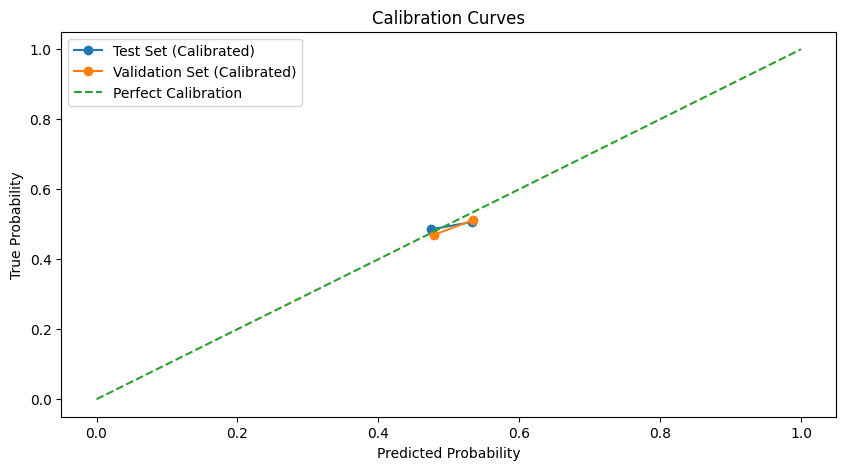

In [24]:
prob_true_test, prob_pred_test = calibration_curve(y_test, y_pred_prob_test_calibrated, n_bins=10)
prob_true_val, prob_pred_val = calibration_curve(y_val, y_pred_prob_val_calibrated, n_bins=10)

plt.figure(figsize=(10, 5))
plt.plot(prob_pred_test, prob_true_test, marker='o', label='Test Set (Calibrated)')
plt.plot(prob_pred_val, prob_true_val, marker='o', label='Validation Set (Calibrated)')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')

plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curves')
plt.legend()
plt.show()

In [25]:
with open('xgboost_model_714.pkl', 'wb') as f:
    pickle.dump(model, f)

In [26]:
with open('xgboost_calibrated_model_714.pkl', 'wb') as f:
    pickle.dump(calibrator_platt, f)

In [27]:
import shap

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

KeyError: 'model'

In [ ]:
with open('shap_values714.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

# Optionally, export the explainer to a pickle file
with open('explainer714.pkl', 'wb') as f:
    pickle.dump(explainer, f)

In [ ]:
X_test.columns